# **1. Import Libraries**

In [27]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Extract Data from XML and store in New Folder**

In [ ]:
def extract_data_from_xml(root_dir):
    xml_path = os.path.join(root_dir, 'words.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    for img in root:
      bbs_of_img = []
      labels_of_img = []

      for bbs in img.findall('taggedRectangles'):
          for bb in bbs:
            if not bb[0].text.isalnum():
              continue
            if "é" in bb[0].text.lower() or 'ñ' in bb[0].text.lower():
              continue
            bbs_of_img.append([
              float(bb.attrib['x']),
              float(bb.attrib['y']),
              float(bb.attrib['width']),
              float(bb.attrib['height'])
            ])
            labels_of_img.append(bb[0].text.lower())

      img_path = os.path.join(root_dir,img[0].text)
      img_paths.append(img_path)
      img_sizes.append((int(img[1].attrib['x']),(int(img[1].attrib['y']))))
      bboxes.append(bbs_of_img)
      img_labels.append(labels_of_img)

    return  img_paths, img_sizes, img_labels, bboxes

In [ ]:
dataset_dir = "drive/MyDrive/Study/AIO/Scene Text Recognition/SceneTrialTrain"
img_paths,img_sizes, img_labels, bboxes = extract_data_from_xml(dataset_dir)



In [ ]:
print("Total images:", len(img_paths))
print("Total bounding boxes:", sum([len(bbs) for bbs in bboxes]))

Total images: 250
Total bounding boxes: 1097


Plot an example

In [ ]:
def plot_image_with_bbs(img_paths,bbs,labels):
  img=cv2.imread(img_paths)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  for idx,bb in enumerate(bbs):
    start_point = (int(bb[0]),int(bb[1]))
    end_point = (int(bb[0]+bb[2]),int(bb[1]+bb[3]))
    color = (0,255,0)
    thickness = 2
    img = cv2.rectangle(img,start_point,end_point,color,thickness)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    line_type = 2
    text_thickness = 2
    label = labels[idx]
    text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)

    label_background_start = (int(bb[0]), int(bb[1]) - text_size[1] - 10)
    label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
    img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)

    cv2.putText(
        img,
        label,
        (int(bb[0]), int(bb[1]) - 5),
        font,
        font_scale,
        font_color,
        line_type
    )

    plt.imshow(img)
    plt.axis( 'off')
    plt.show()

i = random.randint(0,len(img_paths))
plot_image_with_bbs(img_paths[i],bboxes[i],img_labels[i])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def split_bounding_boxes(img_paths,img_labels,bboxes,save_dir):
  os.makedirs(save_dir,exist_ok=True)

  count = 0
  labels = []

  for img_path, img_label, bbs in zip(img_paths,img_labels,bboxes):
    img = Image.open(img_path)
    for label, bb in zip(img_label,bbs):
      #crop image
      cropped_image = img.crop((bb[0],bb[1],bb[0]+bb[2],bb[1]+bb[3]))
      #fillter out if 90% of the cropped image is black or white
      if np.mean(cropped_image) > 220 or np.mean(cropped_image) < 35 :
        continue
      if cropped_image.size[0] < 10 or cropped_image.size[1] < 10:
        continue
      if len(img_label) <3:
        continue
      #save image
      filename = f"{count:06d}.jpg"
      cropped_image.save(os.path.join(save_dir,filename))

      new_img_path = os.path.join(save_dir,filename)
      label = new_img_path + "\t" + label
      labels.append(label)
      count += 1
  print(f"Created {count} image!")
  #write labels to text file
  with open(os.path.join(save_dir,"labels.txt"),"w") as f:
    for label in labels:
      f.write(label + "\n")

In [ ]:
save_dir= "drive/MyDrive/Study/AIO/Scene Text Recognition/datasets/ocr_dataset"
split_bounding_boxes(img_paths,img_labels,bboxes,save_dir)

KeyboardInterrupt: 

# **3. Read Dataset**

In [28]:
save_dir= "drive/MyDrive/Study/AIO/Scene Text Recognition/datasets/ocr_dataset"
# save_dir= "drive/MyDrive/Scene Text Recognition/datasets/ocr_dataset"

root_dir = save_dir
img_paths = []
labels= []

with open(os.path.join(root_dir,"labels.txt"),"r") as f:
  for label in f:
    labels.append(label.strip().split("\t")[1])
    img_paths.append(label.strip().split("\t")[0])

print(f"Total images: {len(img_paths)}")

Total images: 964


In [ ]:
root_dir = "drive/MyDrive/Study/AIO/Scene Text Recognition/datasets/captcha/train"

captcha_img_paths = []
captcha_labels = []

for img_path in os.listdir(root_dir):
  captcha_img_paths.append(os.path.join(root_dir,img_path))

  label = img_path.split(".")[0]
  captcha_labels.append(label)

print(f"Total images: {len(captcha_img_paths)}")


Total images: 0


# **4. Prepare vocabulary**

In [29]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

chars= "".join(letters)

blank_char = "-"
chars += blank_char
vocab_size = len(chars)

print(f"Vocab size: {vocab_size}")
print(f"Vocab: {chars}")

Vocab size: 37
Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-


In [30]:
char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [31]:
idx_to_char

{1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9',
 12: 'a',
 13: 'b',
 14: 'c',
 15: 'd',
 16: 'e',
 17: 'f',
 18: 'g',
 19: 'h',
 20: 'i',
 21: 'j',
 22: 'k',
 23: 'l',
 24: 'm',
 25: 'n',
 26: 'o',
 27: 'p',
 28: 'q',
 29: 'r',
 30: 's',
 31: 't',
 32: 'u',
 33: 'v',
 34: 'w',
 35: 'x',
 36: 'y',
 37: 'z'}

In [ ]:
max_label_len = max([len(label) for label in labels])
print(f"Max label length: {max_label_len}")

Max label length: 14


In [ ]:
def encode(label,char_to_idx,max_label_len):
  encoded_labels = torch.tensor(
      [char_to_idx[char] for char in label],
      dtype = torch.int32
  )
  label_len = len(encoded_labels)
  lengths = torch.tensor(
      label_len,
      dtype = torch.int32
  )
  padded_labels = F.pad(
      encoded_labels,
      (0,max_label_len-label_len),
      value = 0
  )
  return padded_labels,lengths

In [ ]:
def decode(encoded_sequences,idx_to_char,blank_char='-'):
  decoded_sequences = []

  for seq in encoded_sequences:
    decoded_label = []
    prev_char = None
    for token in seq:
      if token != 0:
        char = idx_to_char[token.item()]

        if char != blank_char:
          if char != prev_char or prev_char == blank_char:
            decoded_label.append(char)

      prev_char = char

    decoded_sequences.append(''.join(decoded_label))
  return decoded_sequences

In [ ]:
input_str= "rooad"
input_encoded, input_lengths = encode(input_str,char_to_idx,max_label_len)
print(input_encoded)
print(input_lengths)
print(input_encoded.shape)

input_decoded = decode([input_encoded],idx_to_char)
print(input_decoded)

tensor([29, 26, 26, 12, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=torch.int32)
tensor(5, dtype=torch.int32)
torch.Size([14])
['road']


# **5. Create data preprocrssing function**

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4,
        ),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear = 1),
        transforms.RandomPerspective(distortion_scale=0.5,p=0.5,interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((100,420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),
        ]),
}

# **6. Train, Val, Test split**

In [ ]:
seed = 0
val_size = 0.1
test_size = 0.1
is_suffle = True

X_train,X_val,y_train,y_val = train_test_split(
    img_paths,labels,
    test_size = val_size,
    random_state=seed,shuffle=is_suffle
)
X_train,X_test,y_train,y_test = train_test_split(
    X_train,y_train,
    test_size = test_size,
    random_state=seed,
    shuffle=is_suffle
)

# **7. Create pytorch dataset**

In [ ]:
class STRDataset(Dataset):
  def __init__(
      self,
      X,y,
      char_to_idx,
      max_label_len,
      label_encoder = None,
      transform = None
  ):
    self.transforms = transform
    self.img_paths = X
    self.labels = y
    self.char_to_idx = char_to_idx
    self.max_label_len = max_label_len
    self.label_encoder = label_encoder

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,idx):
    label = self.labels[idx]
    img_path = self.img_paths[idx]
    img = Image.open(img_path).convert("RGB")

    if self.transforms:
      img = self.transforms(img)

    if self.label_encoder:
      encoded_label,label_len = self.label_encoder(label,self.char_to_idx,self.max_label_len)

    return img,encoded_label, label_len

# **8. Create dataloader**

In [ ]:
train_dataset = STRDataset(
    X_train,y_train,
    char_to_idx,
    max_label_len,
    label_encoder = encode,
    transform = data_transforms['train']
)
val_dataset = STRDataset(
    X_val,y_val,
    char_to_idx,
    max_label_len,
    label_encoder = encode,
    transform = data_transforms['val']
)
test_dataset = STRDataset(
    X_test,y_test,
    char_to_idx,
    max_label_len,
    label_encoder = encode,
    transform = data_transforms['val']
)

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 780
Val dataset size: 97
Test dataset size: 87


In [ ]:
train_batch_size = 64
# val_batch_size = 32
test_batch_size = 64*2

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False
    )

test_loader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle = False
    )

['mouth', 'out', 'can', 'low', 'release', 'injury', '3p', 'sence', 'udi', 'computing', 'programing', '83', 'new', 'caution', '15m', 'markers', 'trespasing', 'a', 'please', 'orange', 'of', 'up', 'events', 'high', 'smith', 'software', 'ofice', 'desk', 'service', 'fire', 'you', 'others', 'computer', 'do', 'franklin', 'inteligence', 'council', 't', 'xvi', 'leslie', 'construction', 'pro', 'jeny', 'no', 'word', 'volvo', 'your', 'clements', 'tramp', 'central', 'games', 'serious', 'hofman', 'wiley', '196', 'beardwel', 'revolution', 'manchester', 'and', 'tickets', 'visits', 'specialists', 'of', 'cigaretes']


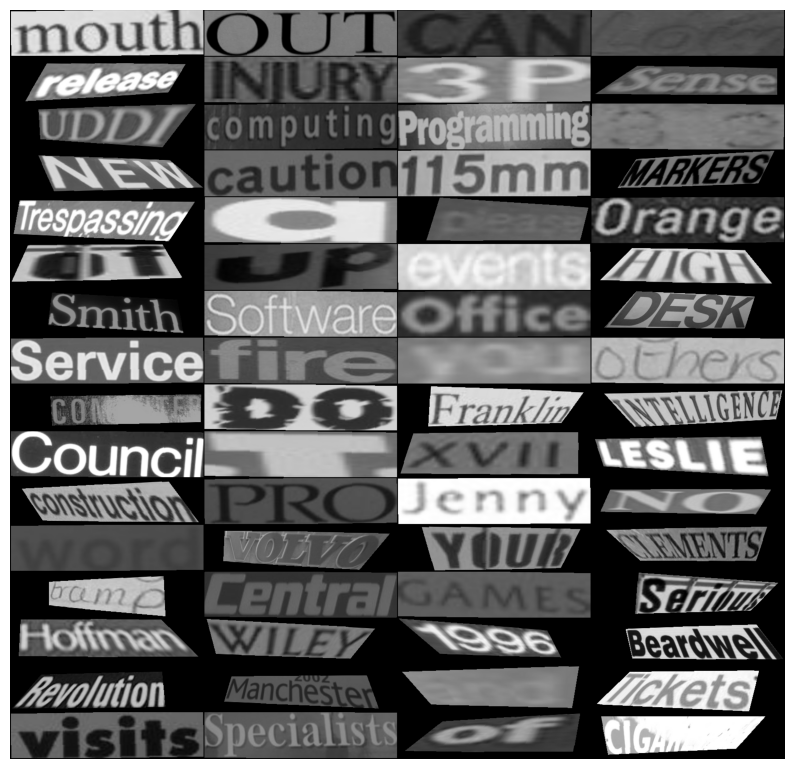

In [ ]:
train_features, train_labels, train_lengths = next(iter(train_loader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")

def show_batch(imgs,labels):
  labels = decode(labels,idx_to_char)
  grid = torchvision.utils.make_grid(imgs,nrow = 4, normalize=True)
  plt.figure(figsize=(10,20))
  plt.imshow(np.transpose(grid,(1,2,0)))
  plt.axis('off')
  print(labels)
  plt.show()

show_batch(train_features,train_labels)

# **9. Create model**

In [ ]:
class CRNN(nn.Module):
  def __init__(
      self,
      vocab_size,
      hidden_size,
      n_layers,
      dropout= 0.2,
      unfreeze_layers = 3
  ):
    super(CRNN,self).__init__()

    backbone = timm.create_model(
        'resnet152',
        in_chans =1,
        pretrained = True
    )
    modules = list(backbone.children())[:-2]
    modules.append(nn.AdaptiveAvgPool2d((1,None)))
    self.backbone = nn.Sequential(*modules)

    #unfreeze the last few layers
    for parameter in self.backbone[-unfreeze_layers:].parameters():
      parameter.requires_grad = True

    self.mapSeq = nn.Sequential(
        nn.Linear(2048,512),
        # nn.BatchNorm1d(hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

    # self.lstm = nn.LSTM(
    #     512,hidden_size,
    #     n_layers,bidirectional = True, batch_first = True,
    #     dropout = dropout if n_layers > 1 else 0
    # )
    self.gru = nn.GRU(
      512,
      hidden_size,
      n_layers,
      bidirectional = True,
      batch_first = True,
      dropout = dropout if n_layers > 1 else 0
    )

    self.layer_norm = nn.LayerNorm(hidden_size*2)

    self.out = nn.Sequential(
        nn.Linear(hidden_size*2,vocab_size),
        nn.LogSoftmax(dim=2)
    )

  def forward(self,x):
    # print(x.shape)

    x = self.backbone(x)
    # print(x.shape)

    x= x.permute(0,3,1,2)
    # print(x.shape)

    x = x.view(x.size(0),x.size(1),-1)
    # print(x.shape)

    x= self.mapSeq(x)
    # print(x.shape)

    x, _ = self.gru(x)
    # print(x.shape)

    x = self.layer_norm(x)
    # print(x.shape)

    x = self.out(x)
    x =x.permute(1,0,2)

    return x

In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CRNN(
    vocab_size = vocab_size,
    hidden_size= hidden_size,
    n_layers = n_layers,
    dropout = dropout_prob,
    unfreeze_layers = unfreeze_layers
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [ ]:
model.eval()
dummy_tensor = torch.rand((64,1,32,100)).to(device)

with torch.no_grad():
  output = model(dummy_tensor)
print(output.shape)

torch.Size([4, 64, 37])


# **10.Training**

In [ ]:
def evaluate(model,data_loader,criterion,device):
  model.eval()
  losses = []
  with torch.no_grad():
    for inputs,labels,labels_len in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels_len = labels_len.to(device)

      outputs = model(inputs)
      logits_lens = torch.full(
          size = (outputs.size(1),),
          fill_value = outputs.size(0),
          dtype = torch.long
      )

      loss = criterion(outputs,labels,logits_lens,labels_len)
      losses.append(loss.item())
  loss = sum(losses)/len(losses)
  return loss


In [25]:
def fit(model,train_loader,val_loader,optimizer,criterion,scheduler,device,epochs):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    # start = time.time()

    batch_train_losses = []

    model.train()
    for idx, (inputs,labels,labels_len) in enumerate(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels_len = labels_len.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)

      logits_lens = torch.full(
          size = (outputs.size(1),),
          fill_value = outputs.size(0),
          dtype = torch.long
      ).to(device)

      loss = criterion(outputs,labels,logits_lens,labels_len)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(
          model.parameters(),
          5
      )
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses)/len(batch_train_losses)
    train_losses.append(train_loss)

    val_loss = evaluate(model,val_loader,criterion,device)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch+1}/{epochs}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}")
    # print(f"EPOCH {epoch + 1}: \tTrain loss: {train_loss:4f}\tVal loss: {val_loss:4f}\t\tTime: {time.time() - start:2f} seconds")


    scheduler.step()

  return train_losses,val_losses


In [26]:
epochs = 100
lr = 5e-4
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size = scheduler_step_size,
    gamma=0.1,
)

train_losses, val_losses = fit(model,train_loader,val_loader,optimizer,criterion,scheduler,device,epochs)

Epoch: 1/100:	Train loss: nan	Val loss: nan
Epoch: 2/100:	Train loss: nan	Val loss: nan


KeyboardInterrupt: 

In [ ]:
val_loss = evaluate(model,val_loader,criterion,device)
test_loss = evaluate(model,test_loader,criterion,device)
print(f"Val loss: {val_loss:.4f}\tTest loss: {test_loss:.4f}")

Val loss: 0.7557	Test loss: 0.9110


In [ ]:
save_model_path = "drive/MyDrive/Study/AIO/Scene Text Recognition/models/ocr_crnn_base_best_final.pt"
torch.save(model.state_dict(),save_model_path)